# Classification - Predict Passenger Survival On Titanic

The goal is to predict whether or not a passenger survived the Titanic based on attributes such as their age, sex, passenger class, where they embarked and so on. Data in this dataset has already been separated in a train and test set.

The dataset comes from: https://www.kaggle.com/c/titanic

## 1. Get the Data:

In [1]:
import pandas as pd
import numpy as np

def load_titanic_data():
    train_data = pd.read_csv("train.csv")
    test_data_pre = pd.read_csv("test.csv")
    test_data_y = pd.read_csv("gender_submission.csv")
    test_data = pd.concat([test_data_y, test_data_pre], axis=1)
    #test_data
    
    return train_data, test_data

train, test = load_titanic_data()

## 2. Data Exploration

### General Exploration

In [2]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


The attributes have the following meaning:
* **Survived**: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
* **Pclass**: passenger class.
* **Name**, **Sex**, **Age**: self-explanatory
* **SibSp**: how many siblings & spouses of the passenger aboard the Titanic.
* **Parch**: how many children & parents of the passenger aboard the Titanic.
* **Ticket**: ticket id
* **Fare**: price paid (in pounds)
* **Cabin**: passenger's cabin number
* **Embarked**: where the passenger embarked the Titanic

We create a copy of the data for exploration and study atrribute types, % of missing values, Noise, Type of distribution.

In [3]:
train_copy = train.copy()
train_copy.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [4]:
train_copy["Ticket"].value_counts()

347082      7
CA. 2343    7
1601        7
347088      6
3101295     6
           ..
315094      1
113514      1
19988       1
335677      1
2672        1
Name: Ticket, Length: 681, dtype: int64

We observe there are numerical attributes (Survived, Pclass, Age, SibSp, Parch, Fare) and categorical attributes (Name, Sex, Ticket, Cabin, Embarked), all correctly labeled.

The Age, Cabin and Embarked attributes are sometimes null:
* Embarked: 0.22%
* Age: 19.87%
* Cabin: 77.10%

Cabins values are mostly missing, we will ignore them for now. The age attribute has most values and will need further analysis but replacing the value with the median age seems reasonable. Embarked is practically complete and will be kept, we will decide if replacing nulls or removing the null rows.

Name will be ignored for now. Also ticket since there are more than 681 unique entries and might be hard to convert to numbers that a model can consume.

### Numerical attributes:

In [5]:
train_copy.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


* **Survived:** Only 38% of passengers survived, this is close to 40%, so accuracy might be an adecuate measure of evaluation. Since the value is an int and we see the min and max are 0 and 1 we know there are indeed only two categories.

* **Age:** varies between .42 and 80, the median is 28 and on average people are 29, this means there is a much higher percent of young people, this might have to be reviewed since most likely age and survival are highly correlated, maybe separating on different strats (Ex. child, adult, middle aged) might be useful.

* **Fare:** shows there is a high difference between lower and higher values, also there are people that payed 0, this should be considered, might these be workers?

* **SibSp and Parch:** Both these attributes have to do with family and are mostly 0 nevertheless it might be useful to combine and create a new attribute "family".

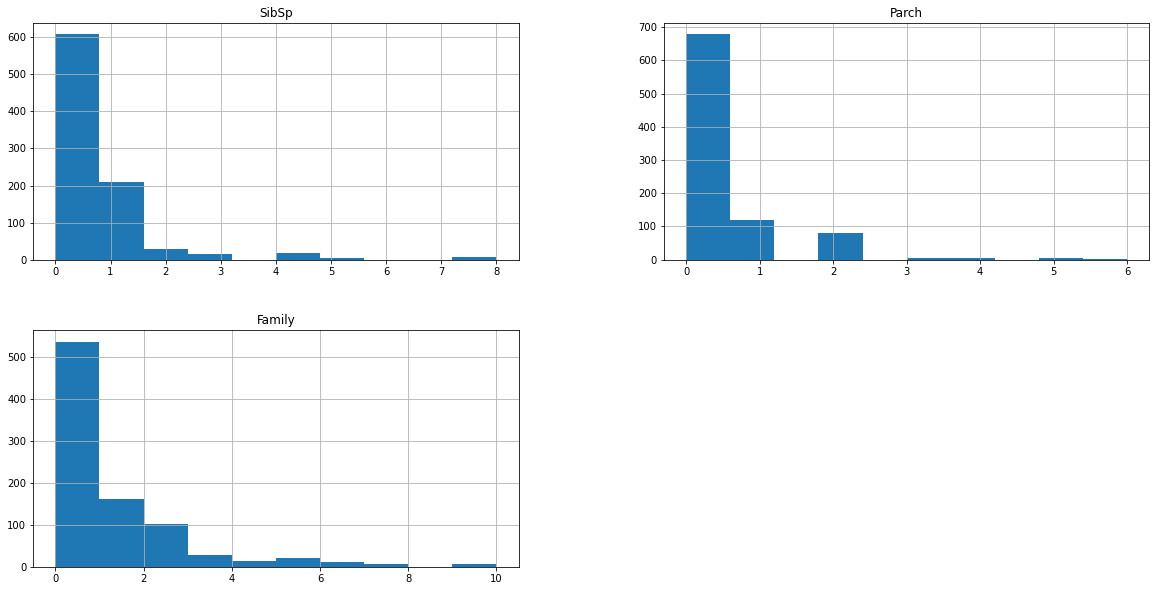

In [6]:
# we will create a function on our pipeline that includes these options and also tests it in our model
train_copy["Family"] = train_copy["SibSp"] + train_copy["Parch"]

%matplotlib inline
import matplotlib.pyplot as plt
train_copy.loc[:,["SibSp", "Parch", "Family"]].hist(bins=10, figsize=(20,10))
plt.show()

In [7]:
train_copy[["Family", "Survived"]].groupby(['Family']).mean()

,Survived
Family,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


We see that there are more than 600 people that have no siblings and parents or children, when combined there is only more than 500 that have no relatives, also we see that parch is quite incomplete yet the family has many more numbers per strata. We will add the option to combine these on a pipeline and see our performance.

We also notice that people that have no family have a 30% survival rate, vs people with 1 to 3 family members have more than 50% chance, it might be useful to try a model with a categorical value if you have family or not.

Now lets compare age by groups (every 15 years) and as raw numbers, we will plot cases that survived.

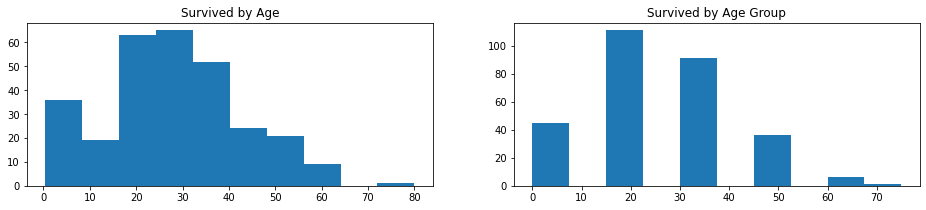

In [8]:
%matplotlib inline

train_copy["age_group"] = train_copy["Age"] // 15 * 15

plot_1 = train_copy["Age"][train_copy["Survived"] == 1]
plot_2 = train_copy["age_group"][train_copy["Survived"] == 1]


figure, axis = plt.subplots(1,2, figsize=(16,3))
  
# For Age
axis[0].hist(plot_1)
axis[0].set_title("Survived by Age")
  
# For Age Group
axis[1].hist(plot_2)
axis[1].set_title("Survived by Age Group")

# Combine all the operations and display
axis[1].figsize=(20, 20)
plt.show()


### Categorical Attributes

We see that even though third class is the most common it has the lowest survival rate, survival seems to be higher by class.

In [9]:
pclass = train_copy[["Pclass", "Survived"]].groupby(["Pclass"]).mean()
pclass2 = pd.DataFrame(train_copy["Pclass"].value_counts()/len(train_copy["Pclass"])).reset_index()
pclass2 = pclass2.rename(columns={'Pclass': 'Total', 'index':'Pclass'}).set_index("Pclass")
pclass = pd.concat([pclass, pclass2], axis=1)
pclass

,Survived,Total
Pclass,,
1,0.629630,0.242424
2,0.472826,0.206510
3,0.242363,0.551066


Even though only 35% of the population is female, they are 74% of survivals, it is clearly a very important factor.

In [10]:
sex_df = train_copy[["Sex", "Survived"]].groupby(['Sex']).mean()
sex_df2 = pd.DataFrame(train_copy["Sex"].value_counts()/len(train_copy["Sex"])).reset_index()
sex_df2= sex_df2.rename(columns={'Sex': 'Total', 'index':'Sex'}).set_index("Sex")
sex_df = pd.concat([sex_df, sex_df2], axis=1)
sex_df

,Survived,Total
Sex,,
female,0.742038,0.352413
male,0.188908,0.647587


The Embarked attribute tells us where the passenger embarked: C=Cherbourg, Q=Queenstown, S=Southampton. We see that Cherbourg has the highest survival rate even though they are 20% of the total.

In [11]:
embarked_df = train_copy[["Embarked", "Survived"]].groupby(['Embarked']).mean()
embarked_df2 = pd.DataFrame(train_copy["Embarked"].value_counts()/len(train_copy["Embarked"])).reset_index()
embarked_df2= embarked_df2.rename(columns={'Embarked': 'Total', 'index':'Embarked'}).set_index("Embarked")
embarked_df = pd.concat([embarked_df, embarked_df2], axis=1)
embarked_df

,Survived,Total
Embarked,,
C,0.553571,0.188552
Q,0.389610,0.086420
S,0.336957,0.722783


## 3. Data Preparation

We will build our preprocessing pipelines, first we will create a custom class to select which attributes to use, our final pipeline will process different iterations of these features and select which is best. The possible transformations are the following:
* add_family: this will add SibSp + Parch and remove those columns, a new attribute is called "Family"
* change_age: we change the age to a ordinal value
* family_class: adds a binary categorical value, 1 if the person has family, 0 if not. Removes SibSp, Parch and Family if this attribute exists


In [12]:
from sklearn.base import BaseEstimator, TransformerMixin

# This will automatically select the correct columns to select
class SelectAttributes(BaseEstimator, TransformerMixin):
    def __init__(self, add_family=False, change_age=False, family_class=False):
        self.add_family = add_family
        self.change_age = change_age
        self.family_class = family_class
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        columns = ["Survived", "Pclass", "Sex", "Age", "SibSp", 
                        "Parch", "Fare", "Embarked"]
        
        def remove_verifier(name, column):
            if name in column:
                column.remove(name)
        
        # We add the column to see how many family members there are
        if self.add_family:
            X["Family"] = X["SibSp"] + X["Parch"]
            columns.append("Family")
            remove_verifier("SibSp", columns)
            remove_verifier("Parch", columns)
        # The age is changed from year to segment
        if self.change_age:
            X["Age_Group"] = X["Age"] // 15
            columns.append("Age_Group")
            remove_verifier("Age", columns)
        
        # Checks if there are family members or not
        if self.family_class:
            X["Has_Family"] = X["SibSp"] + X["Parch"]
            X["Has_Family"]= X["Has_Family"].apply(lambda x: 0 if x==0 else 1)
            columns.append("Has_Family")
            remove_verifier("SibSp", columns)
            remove_verifier("Parch", columns)
            remove_verifier("Family", columns)
        
        X = X.loc[:,columns]
        
        return X

There are a total of 2^3= 8 combinations, nevertheless since "Has_Family" deletes the "Family" category this diminishes the possible outcomes to 6 (the combination true, false, true & false, false, true outputs the same result; the same happens between false, true, true & true, true, true).

**We will test all possible combinations to select the best one!!**

In [13]:
# This function identifies the categorical and numeric columns
def ColumnIdentifier(X):
    num_columns = ["Pclass", "Age", "SibSp", "Parch", "Fare", "Family"]
    cat_columns = ["Sex", "Embarked", "Age_Group", "Has_Family"]
    if "Family" in X.columns:
        num_columns.remove("SibSp")
        num_columns.remove("Parch")
    else: num_columns.remove("Family")
    
    if "Has_Family" in X.columns:
        if "Family" in num_columns:
            num_columns.remove("Family")
        else: 
            num_columns.remove("SibSp")
            num_columns.remove("Parch")
    else: cat_columns.remove("Has_Family")
    
    if "Age_Group" in X.columns:
        num_columns.remove("Age")
    else:
        cat_columns.remove("Age_Group")
    return num_columns, cat_columns

### **Numeric Attributes:** 
We create our pipeline for numerical attributes, our pipeline will remove numeric NaNs and scale the attributes.

In [14]:
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler

num_pipeline = Pipeline([
    ('remove_nans', SimpleImputer(strategy="median")),
    ('scale', StandardScaler()),
])

### **Categorical Attributes:**

We will need an imputer for the string categorical values, we select the most common occurence and apply a OneHotEncoder

In [15]:
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X):
        return X.fillna(self.most_frequent_)

In [16]:
from sklearn.preprocessing import OneHotEncoder

cat_pipeline = Pipeline([
    ('imputer', MostFrequentImputer()),
    ('cat_encoder', OneHotEncoder(sparse=False)),
])

### Complete Data Preparation Pipeline:

We combine the numeric and categorical pipeline into one final model.

In [17]:
from sklearn.compose import ColumnTransformer

X_train = SelectAttributes().fit_transform(train)

num_columns, cat_columns = ColumnIdentifier(X_train)

preprocess_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_columns),
    ("one_hot", cat_pipeline, cat_columns),
])

X_train = preprocess_pipeline.fit_transform(X_train)
X_train

array([[ 0.82737724, -0.56573646,  0.43279337, ...,  0.        ,
         0.        ,  1.        ],
       [-1.56610693,  0.66386103,  0.43279337, ...,  1.        ,
         0.        ,  0.        ],
       [ 0.82737724, -0.25833709, -0.4745452 , ...,  0.        ,
         0.        ,  1.        ],
       ...,
       [ 0.82737724, -0.1046374 ,  0.43279337, ...,  0.        ,
         0.        ,  1.        ],
       [-1.56610693, -0.25833709, -0.4745452 , ...,  1.        ,
         0.        ,  0.        ],
       [ 0.82737724,  0.20276197, -0.4745452 , ...,  0.        ,
         1.        ,  0.        ]])

In [18]:
y_train = train["Survived"]

# 4. Select & Train Model

On this section we will select different many models with random search and cross validation and select the top 5 models.

In [19]:
# We create all the attribute combinations to test them and know which parameters we will use in our model

import itertools
l = [False, True]
preprocess_options = list(itertools.product(l, repeat=3))

#We create a dictionary with all the different model parameters
models = dict()
#KNN
models = dict()


embarked_df = pd.concat([embarked_df, embarked_df2], axis=0)

In [20]:
preprocess_options

[(False, False, False),
 (False, False, True),
 (False, True, False),
 (False, True, True),
 (True, False, False),
 (True, False, True),
 (True, True, False),
 (True, True, True)]

In [21]:
def preparation(data, af, ca, fc):
    X_source = SelectAttributes(add_family=af,
                               change_age=ca,
                               family_class=fc).fit_transform(data)

    num_columns, cat_columns = ColumnIdentifier(X_source)

    preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_columns),
        ("one_hot", cat_pipeline, cat_columns),
    ])
    X_train = preprocess_pipeline.fit_transform(X_source)
    return X_train

In [22]:
model_results = pd.DataFrame(columns=['params','mean_test_score', 'model'])

### Testing Different Models:

We will test different classifiers using Randomized Search with Cross Validation and generate a table of all the trained models and their hyperparameters.

We will train:
- KNN
- Random Forest


**Note:** On this notebook we will only use these two algorithms to test due to the amount of parameter options and hyperparameters to consider which increases processing time significantly, especially on the case of SVM. There are many other algorithms that could be used, among them:
- SVM
- Logistic Regression
- GaussianNB
- SGD Classifier
- Gradient Boosting Classifier

In [23]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

for line in preprocess_options:
    add_family = line[0]
    change_age = line[1]
    family_class = line[2]
    
    X_train = preparation(train, add_family, change_age, family_class)
    
    #KNN
    k_range=range(1,26)
    options=['uniform', 'distance']
    param_distribs = {'n_neighbors':k_range, 'weights':options,}
    knn = KNeighborsClassifier()
    knn_rand = RandomizedSearchCV(knn, param_distribs, 
                                  cv=10, scoring='accuracy', n_iter=10, random_state=42)
    knn_rand.fit(X_train, y_train)
    knn_table = pd.DataFrame(knn_rand.cv_results_)[['params','mean_test_score']]
    knn_table["model"] = "knn"
    
    # Random Forest
    param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),}
    forest_reg = RandomForestClassifier()
    rnd_search = RandomizedSearchCV(forest_reg, param_distributions=param_distribs,
                                n_iter=10, cv=10, scoring='accuracy', random_state=42)
    rnd_search.fit(X_train, y_train)
    rnd_table = pd.DataFrame(rnd_search.cv_results_)[['params','mean_test_score']]
    rnd_table['model'] = "rforest"
    
    """
    # SVM
    param_distribs = {'C': [0.1,1, 10, 100], 
                      'gamma': [1,0.1,0.01,0.001],
                      'kernel': ['rbf', 'poly', 'sigmoid']}
    svm = SVC()
    svm_search = RandomizedSearchCV(svm, param_distributions=param_distribs,
                                n_iter=10, cv=10, scoring='accuracy', random_state=42)

    svm_search.fit(X_train, y_train)
    svm_table = pd.DataFrame(svm_search.cv_results_)[['params','mean_test_score']]
    rnd_table['model'] = "svm"
    """
    
    # We now join the model results to the final table
    temp_table = pd.concat([knn_table, rnd_table], axis=0)
    temp_table['variables'] = [line]*len(temp_table)
    model_results = pd.concat([model_results, temp_table], axis=0)

We have now tested the different models with many parameters and hyperparameters, we will select the 5 best ones based on accuracy and see their performance with our test set.

In [24]:
print("Total Number of Models Run:", model_results.shape[0])
print("Best 5 Scores:")
final_selection = model_results.sort_values("mean_test_score", ascending=False).head().reset_index().iloc[:,1:]
final_selection

Total Number of Models Run: 160
Best 5 Scores:


,params,mean_test_score,model,variables
0,"{'max_features': 7, 'n_estimators': 180}",0.830574,rforest,"(True, False, False)"
1,"{'max_features': 7, 'n_estimators': 180}",0.823845,rforest,"(True, True, False)"
2,"{'max_features': 5, 'n_estimators': 100}",0.823820,rforest,"(True, True, False)"
3,"{'max_features': 7, 'n_estimators': 180}",0.821623,rforest,"(True, False, True)"
4,"{'max_features': 7, 'n_estimators': 180}",0.821623,rforest,"(False, True, True)"


# 5. Testing Final Models

In [25]:
from sklearn.metrics import roc_auc_score

for row in range(final_selection.shape[0]):
    variables = final_selection.loc[row, "variables"]
    
    X_prep = SelectAttributes(add_family=variables[0],
                           change_age=variables[1],
                           family_class=variables[2])
    X_source = X_prep.fit_transform(train)
    X_source_test = X_prep.fit_transform(test)
    
    num_columns, cat_columns = ColumnIdentifier(X_source)
    preprocess_pipeline = ColumnTransformer([
    ("num", num_pipeline, num_columns),
    ("one_hot", cat_pipeline, cat_columns),
    ])
    
    X_train = preprocess_pipeline.fit_transform(X_source)

    if final_selection.loc[row, 'model'] == 'rforest':
        reg = RandomForestClassifier(**final_selection.loc[row, "params"],
                                    random_state=42)

    else:
        reg = KNeighborsClassifier(**final_selection.loc[row, "params"],
                                    random_state=42)
    
    reg.fit(X_train, y_train)
    
    num_columns, cat_columns = ColumnIdentifier(X_source_test)

    preprocess_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_columns),
        ("one_hot", cat_pipeline, cat_columns),
    ])
    X_test = preprocess_pipeline.fit_transform(X_source_test)
    prediction = reg.predict(X_test)
    
    print("Algorithm:", final_selection.loc[row, 'model'])
    print("Parameters:", variables)
    print("Hyperparameters:", final_selection.loc[row, "params"])
    print("ROC AUC Score:", roc_auc_score(test.Survived, prediction))
    print("")

Algorithm: rforest
Parameters: (True, False, False)
Hyperparameters: {'max_features': 7, 'n_estimators': 180}
ROC AUC Score: 0.8242481203007519

Algorithm: rforest
Parameters: (True, True, False)
Hyperparameters: {'max_features': 7, 'n_estimators': 180}
ROC AUC Score: 0.805451127819549

Algorithm: rforest
Parameters: (True, True, False)
Hyperparameters: {'max_features': 5, 'n_estimators': 100}
ROC AUC Score: 0.7932330827067668

Algorithm: rforest
Parameters: (True, False, True)
Hyperparameters: {'max_features': 7, 'n_estimators': 180}
ROC AUC Score: 0.8012218045112782

Algorithm: rforest
Parameters: (False, True, True)
Hyperparameters: {'max_features': 7, 'n_estimators': 180}
ROC AUC Score: 0.7861842105263158



We observe that on the test set the 2 best models out of the 5 with an accuracy of 82-83% both add the column with the number of family members that where on the ship. Also both models do not consider the dummy variable if the person has family or not nor the age group segmentation.

There are other ways to improve the model, like including other parameters that where ignored or other feature transformations. Also running other machine learning algorithms that werent run due to processing time, nevertheless a 82% accuracy is quite good.